In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, urllib, itertools, shutil, random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import PIL
import torch

In [ ]:
train_on_GPU = torch.cuda.is_available()
if train_on_GPU:
  print("CUDA is avaible")
else:
  print("On CPU")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is avaible


Теперь надо подгрузить данные

Если не распаковывается, попробовать убрать или добавить / или посмотреть путь к файлу

In [ ]:
!unzip Fisher.zip -d extracted_files

Archive:  Fisher.zip
   creating: extracted_files/Fisher/
   creating: extracted_files/Fisher/testset/
  inflating: extracted_files/Fisher/testset/pic_000.jpg  
 extracting: extracted_files/Fisher/testset/pic_001.jpg  
  inflating: extracted_files/Fisher/testset/pic_002.jpg  
  inflating: extracted_files/Fisher/testset/pic_003.jpg  
  inflating: extracted_files/Fisher/testset/pic_004.jpg  
   creating: extracted_files/Fisher/train/
   creating: extracted_files/Fisher/train/golavl/
  inflating: extracted_files/Fisher/train/golavl/pic_000.jpg  
 extracting: extracted_files/Fisher/train/golavl/pic_001.jpg  
  inflating: extracted_files/Fisher/train/golavl/pic_002.jpg  
  inflating: extracted_files/Fisher/train/golavl/pic_003.jpg  
 extracting: extracted_files/Fisher/train/golavl/pic_004.jpg  
  inflating: extracted_files/Fisher/train/golavl/pic_005.jpg  
 extracting: extracted_files/Fisher/train/golavl/pic_006.jpg  
  inflating: extracted_files/Fisher/train/golavl/pic_007.jpg  
  inflatin

In [ ]:
!ls

extracted_files  Fisher.zip  sample_data


In [ ]:
import os

# Список файлов в папке train
print(os.listdir('./extracted_files/Fisher/train/'))

['rotan', 'shuka', 'sudak', 'lesh', 'karas', 'golavl', 'peskar', 'sazan', 'harius', 'plotva', 'som', 'ukleika', 'okun']


In [ ]:
!ls extracted_files

Fisher


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

Класс

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from pathlib import Path
from torchvision import transforms


In [ ]:
class FishDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    self.files = files
    self.mode = mode
    self.len = len(self.files)
    self.labels = []
    self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    if self.mode not in DATA_MODES:
      print("Что - то не то с режимами работы")


    with open('label_encoder.pkl', 'rb') as le_dump_file:
      self.label_encoder = pickle.load(le_dump_file)

    if self.mode != "test":
      self.labels = [path.parent.name for path in self.files]

  def __len__(self):
    return self.len

  def load_sample(self, file):
    image = Image.open(file)
    if image.mode != 'RGB':
      image = image.convert('RGB')
    image.load()
    return image

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)


  def __getitem__(self, idx):
      file_path = self.files[idx]
      image = self.load_sample(file_path)
      image = self._prepare_sample(image)
      image = self.transform(image)

      if self.mode == 'test':
          return image
      else:
          label = self.labels[idx]
          label_id = self.label_encoder.transform([label])[0]
          label_id = torch.tensor(label_id, dtype=torch.long)
          return image, label_id




In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)



In [ ]:
TRAIN_DIR = Path('./extracted_files/Fisher/train/')
TEST_DIR = Path('./extracted_files/Fisher/testset/')

In [ ]:
TRAIN_DIR

PosixPath('extracted_files/Fisher/train')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_files

[PosixPath('extracted_files/Fisher/train/golavl/pic_000.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_001.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_002.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_003.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_004.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_005.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_006.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_007.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_008.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_009.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_010.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_011.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_012.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_013.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_014.jpg'),
 PosixPath('extracted_files/Fisher/train/golavl/pic_015

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(train_val_labels)

LabelEncoder()

In [ ]:
with open('train_files.pkl', 'wb') as f:
    pickle.dump(train_files, f)

with open('val_files.pkl', 'wb') as f:
    pickle.dump(val_files, f)

# Сохраняем LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Списки файлов и LabelEncoder сохранены.")

Списки файлов и LabelEncoder сохранены.


Теперь label_encoder обучен отдельно вне класса, и все сохранено в файлы

In [ ]:
val_dataset = FishDataset(val_files, mode='val')
train_dataset = FishDataset(train_files, mode='train')

Надо бы сохранить в файлики. Да, вы можете зафиксировать train_dataset и val_dataset, сохранив информацию о разделении данных и кодировщик меток (label encoder). Это гарантирует, что при загрузке обученной модели и предсказании меток классов, вы будете использовать то же самое разделение данных и ту же самую кодировку меток, что и при обучении.

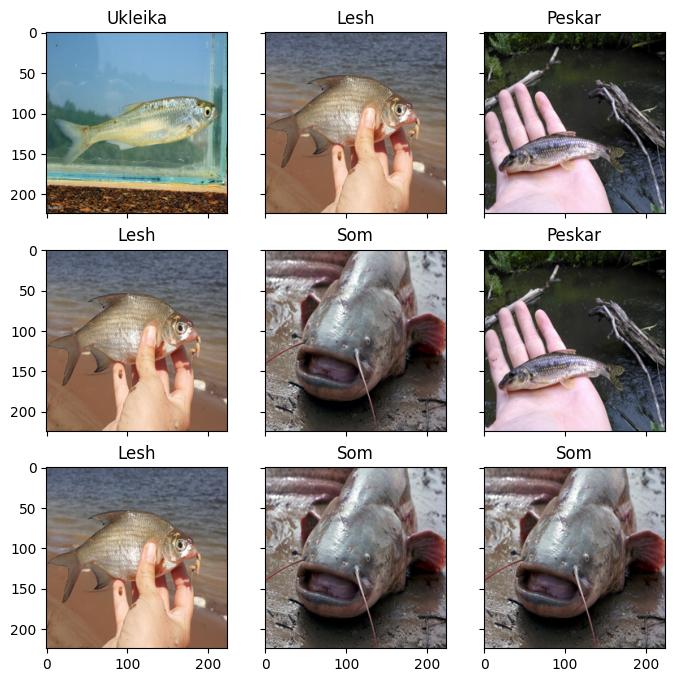

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**Теперь мне надо обучить сеть, сохранить ее. А далее сохраненную сеть и сохраненные файлы и лэйбл энкодер передать в телеграм**

**НЕЙРО ЧАСТЬ**


Данные подгрузили, Вайбик. Теперь Трансформер заюзать


In [ ]:
from transformers import ViTForImageClassification
from transformers import ViTImageProcessor, ViTModel
import torch.nn as nn
import torch.optim as optim

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader

# Создание DataLoader для обучающего и валидационного наборов
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)

# Замена слоя классификатора
num_classes = 13  # Укажите нужное количество классов
model.classifier = nn.Linear(model.config.hidden_size, num_classes)
# Перенос модели на GPU (если доступно)

model.to(DEVICE)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
num_epochs = 10  # Количество эпох

for epoch in range(num_epochs):
    model.train()  # Устанавливаем модель в режим обучения
    running_loss = 0.0
    #print("Форма входного тензора перед моделью:", images.shape)
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Перенос на GPU

        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(images)  # Прямой проход
        loss = criterion(outputs.logits, labels)  # Вычисляем потерю
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновляем веса

        running_loss += loss.item()

    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря: {running_loss/len(train_loader):.4f}")

    # Валидация после каждой эпохи
    model.eval()  # Устанавливаем модель в режим оценки
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            val_loss += criterion(outputs.logits, labels).item()
            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Валидационная потеря: {val_loss/len(val_loader):.4f}, Точность: {val_accuracy:.2f}%")

Эпоха 1/10, Потеря: 1.6784
Валидационная потеря: 0.7092, Точность: 91.69%
Эпоха 2/10, Потеря: 0.3054
Валидационная потеря: 0.2354, Точность: 96.31%
Эпоха 3/10, Потеря: 0.0693
Валидационная потеря: 0.1574, Точность: 96.92%
Эпоха 4/10, Потеря: 0.0289
Валидационная потеря: 0.1301, Точность: 97.23%
Эпоха 5/10, Потеря: 0.0175
Валидационная потеря: 0.1213, Точность: 97.23%
Эпоха 6/10, Потеря: 0.0122
Валидационная потеря: 0.1141, Точность: 96.92%
Эпоха 7/10, Потеря: 0.0091
Валидационная потеря: 0.1097, Точность: 96.92%
Эпоха 8/10, Потеря: 0.0071
Валидационная потеря: 0.1057, Точность: 96.62%
Эпоха 9/10, Потеря: 0.0057
Валидационная потеря: 0.1037, Точность: 96.62%
Эпоха 10/10, Потеря: 0.0047
Валидационная потеря: 0.1011, Точность: 96.62%


Сохранение модели:

In [ ]:
torch.save(model.state_dict(), "vit_fish_classifier.pth")
print("Модель сохранена!")

Модель сохранена!


Теперь предсказание

In [ ]:
from transformers import ViTForImageClassification
import torch
import torch.nn as nn


num_classes = 13
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)

model.classifier = nn.Linear(model.config.hidden_size, num_classes)

model.load_state_dict(torch.load("/content/vit_fish_classifier.pth"))

model.eval()


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

print("Модель загружена!")

<ipython-input-34-11008264598e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/vit_fish_classifier.pth"))


Модель загружена!


**Кусок кода для теста внутри проекта**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# загрузка и подготовка изображения
def prepare_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Добавляем размерность батча
    return image_tensor

# получение предсказания
def predict(model, image_path):
    model.eval()
    with torch.no_grad():
        image_tensor = prepare_image(image_path)
        image_tensor = image_tensor.to(DEVICE)

        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.logits, 1)

    return predicted.item()  # Возвращаем предсказанный класс


In [ ]:
# Пример использования функции predict
image_path = "/fish18.jpg"
predicted_class = predict(model, image_path)

# Декодирование класса
predicted_label = train_dataset.label_encoder.inverse_transform([predicted_class])
print(f"Предсказанный класс: {predicted_label[0]}")

Предсказанный класс: karas


**ТЕЛЕГРАМ БОТ**

In [ ]:
pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 11.0 MB/s eta 0:00:00


In [ ]:
import telebot, numpy as np, os
import torch
from PIL import Image
import io
import torch
from torchvision import transforms
from PIL import Image

In [ ]:
token = '7590508563:AAGE-kJpyklgL9kLQFHorP7Bem1saAqMZew'

In [ ]:
bot = telebot.TeleBot(token)
welcome_message = '''Добро пожаловать! Я помогаю начинающим рыболовам определять улов по фотографии.
На данный момент различаю 13 видов рыб России.
Желательно, чтобы рыба в кадре была в горизонатльном положении и соизмерима с размеров фотографии'''

In [ ]:
classes = {'peskar': "Пескарь", 'sazan': "Сазан", 'ukleika': "Уклейка", 'rotan': "Ротан", 'golavl': "Голавль", 'sudak': "Судак",
           'shuka': "Щука", 'lesh': "Лещ", 'karas': "Карась", 'harius': "Хариус", 'som': "Сом", 'okun': "Окунь", 'plotva': "Плотва"}

In [ ]:
@bot.message_handler(commands=['start'])
def welcome(message):
    bot.reply_to(message, welcome_message)

In [ ]:
@bot.message_handler(content_types=['photo'])
def get_photo(message):
    # Get an image from chat
    fileID = message.photo[-1].file_id
    file_info = bot.get_file(fileID)
    downloaded_file = bot.download_file(file_info.file_path)

    # Get a prediction from model
    answer = predict_fish(downloaded_file)

    # Send an answer to the use
    bot.reply_to(message, answer)


In [ ]:
@bot.message_handler(func=lambda message: True)
def echo_all(message):
	bot.reply_to(message, 'Прикрепите фотографию и я попробую определить рыбу! Желательно, чтобы рыба в кадре была в горизонатльном положении и соизмерима с размеров фотографии')



In [ ]:
Тут мы загрузим уже сохраненный label_encoder

In [ ]:


# загрузка и подготовка изображения
def prepare_image(image):
    image = Image.open(io.BytesIO(image))
    image = image.convert('RGB')
    image = image.resize((224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Добавляем размерность батча
    return image_tensor

# получение предсказания
def predict_fish(image_path):
    with open('label_encoder.pkl', 'rb') as f:
      label_encoder = pickle.load(f)
    model.eval()
    with torch.no_grad():
        image_tensor = prepare_image(image_path)
        image_tensor = image_tensor.to(DEVICE)

        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.logits, 1)
        predicted_class_name = label_encoder.inverse_transform([predicted.item()])[0]

        predicted_fish = classes[predicted_class_name]

    return  predicted_fish

In [ ]:
bot.polling()